In [405]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from datasets import load_dataset, concatenate_datasets

# Exercise 6: Attention

# Loading data

In [406]:
from gensim.downloader import load as gensim_load

glove = gensim_load("glove-wiki-gigaword-100")

In [407]:
full_ds_dict = load_dataset("imdb")
ds_train_full = full_ds_dict["train"]
ds_test_full = full_ds_dict["test"]

In [408]:
from datasets import Dataset as HFDataset


def sample_imdb(ds: HFDataset, n_samples: int) -> HFDataset:
    """
    Sample n_samples from the imdb dataset, ensuring that the dataset is balanced.
    """
    # How many samples per class
    n_per_class = n_samples // 2

    # Filter each class
    pos = (
        ds.filter(lambda x: x["label"] == 1).shuffle(seed=42).select(range(n_per_class))
    )
    neg = (
        ds.filter(lambda x: x["label"] == 0).shuffle(seed=42).select(range(n_per_class))
    )

    # Combine and shuffle
    balanced = concatenate_datasets([pos, neg]).shuffle(seed=42)

    return balanced


In [409]:
TRAIN_SAMPLES = 1000

assert isinstance(ds_train_full, HFDataset)
ds_train = sample_imdb(ds_train_full, TRAIN_SAMPLES)

assert (
    ds_train.filter(lambda x: x["label"] == 1).num_rows
    == ds_train.filter(lambda x: x["label"] == 0).num_rows
)

In [410]:
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

# Tokenization

In [411]:
import re


def tokenize(review: str) -> list[str]:
    # Convert to lowercase
    text = review.lower()

    # Remove all numbers entirely from the text
    text = re.sub(r"\d+", "", text)

    # on word boundaries and ignores punctuation
    tokens: list[str] = re.findall(r"\w+", text)

    return tokens


sample_sentence = "This is a sentence with an unknown word: supermuel"

tokenized = tokenize(sample_sentence)
tokenized[:15]

['this', 'is', 'a', 'sentence', 'with', 'an', 'unknown', 'word', 'supermuel']

In [412]:
from typing import Any

UNK_TOKEN = "<unk>"


def remove_tokens_not_in_glove(
    tokens: list[str],
    glove: Any,
    unk_token: str = UNK_TOKEN,
) -> list[str]:
    return [token if token in glove else unk_token for token in tokens]


PAD_TOKEN = "<pad>"


def pad_or_truncate(
    tokens: list[str],
    sequence_length: int,
    pad_token: str = PAD_TOKEN,
) -> list[str]:
    truncated = tokens[:sequence_length]
    return truncated + [pad_token] * (sequence_length - len(truncated))


with_tokens_removed = remove_tokens_not_in_glove(tokenized, glove=glove)
print(with_tokens_removed)

padded = pad_or_truncate(with_tokens_removed, sequence_length=15)
print(padded)

['this', 'is', 'a', 'sentence', 'with', 'an', 'unknown', 'word', '<unk>']
['this', 'is', 'a', 'sentence', 'with', 'an', 'unknown', 'word', '<unk>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [413]:
def preprocess_review(
    review: str,
    sequence_length: int,
    glove: Any,
    unk_token: str = UNK_TOKEN,
    pad_token: str = PAD_TOKEN,
) -> list[str]:
    tokens = tokenize(review)
    tokens = remove_tokens_not_in_glove(tokens, glove, unk_token)
    tokens = pad_or_truncate(tokens, sequence_length, pad_token)
    return tokens


preprocess_review(sample_sentence, sequence_length=15, glove=glove)

['this',
 'is',
 'a',
 'sentence',
 'with',
 'an',
 'unknown',
 'word',
 '<unk>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

## Tokenize IMDB

In [414]:
TRAIN_SAMPLES = 1000
ds_train = sample_imdb(ds_train, TRAIN_SAMPLES)


def pre_process_dataset(
    ds: HFDataset,
    sequence_length: int,
    glove: Any,
    unk_token: str = UNK_TOKEN,
    pad_token: str = PAD_TOKEN,
) -> tuple[HFDataset, list[str], dict[str, int], dict[int, str]]:
    ds = ds.map(
        lambda x: {
            "tokens": preprocess_review(
                x["text"], sequence_length, glove, unk_token, pad_token
            )
        }
    )

    vocab: list[str] = sorted(
        list(set(token for review in ds["tokens"] for token in review))
    )

    if PAD_TOKEN not in vocab:
        vocab.insert(0, PAD_TOKEN)
    if UNK_TOKEN not in vocab:
        vocab.insert(1, UNK_TOKEN)

    assert vocab[0] == PAD_TOKEN
    assert vocab[1] == UNK_TOKEN

    word_to_idx = {word: i for i, word in enumerate(vocab)}
    idx_to_word = {i: word for word, i in word_to_idx.items()}

    ds = ds.map(lambda x: {"input_ids": [word_to_idx[token] for token in x["tokens"]]})

    return ds, vocab, word_to_idx, idx_to_word


ds_train, vocab, word_to_idx, idx_to_word = pre_process_dataset(
    ds_train, sequence_length=15, glove=glove
)
ds_train

Map: 100%|██████████| 1000/1000 [00:00<00:00, 30686.14 examples/s]


Dataset({
    features: ['text', 'label', 'tokens', 'input_ids'],
    num_rows: 1000
})

In [415]:
ds_train[0]["tokens"][:15], ds_train[0]["input_ids"][:15]

(['the',
  'cast',
  'of',
  'this',
  'film',
  'contain',
  'some',
  'of',
  'new',
  'zealander',
  's',
  'better',
  'actors',
  'many',
  'of'],
 [2810,
  431,
  1969,
  2831,
  1057,
  589,
  2629,
  1969,
  1910,
  3174,
  2421,
  291,
  30,
  1726,
  1969])

In [416]:
print(f"Vocabulary size: {len(word_to_idx)}")

Vocabulary size: 3181


## Vectorize

In [417]:
def create_embedding_matrix(glove: Any, word_to_idx: dict[str, int]) -> torch.Tensor:
    """
    Create an embedding matrix from a GloVe model and a word-to-index mapping.

    Args:
        glove: The GloVe model instance.
        word_to_idx: Mapping from word to index.

    Returns:
        A torch.Tensor of shape (vocab_size, embedding_dim).
    """
    embedding_dim: int = glove.vector_size  # type: ignore
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, i in word_to_idx.items():
        if word in glove:
            embedding_matrix[i] = glove[word]  # type: ignore
        # else, it remains a zero vector (for <unk>, <pad>, etc.)
    embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix_tensor


embedding_matrix = create_embedding_matrix(glove, word_to_idx)
print(f"{embedding_matrix.shape=}")

embedding_matrix.shape=torch.Size([3181, 100])


In [418]:
class IMDBReviewDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for the IMDB reviews.
    It takes a Hugging Face Dataset object and prepares items for PyTorch.
    """

    def __init__(self, hf_dataset: HFDataset):
        self.hf_dataset = hf_dataset
        if "input_ids" not in self.hf_dataset.column_names:
            raise ValueError("input_ids column not found in dataset")
        if "label" not in self.hf_dataset.column_names:
            raise ValueError("label column not found in dataset")

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index and converts it to PyTorch tensors.
        """
        # Get the sample from the Hugging Face dataset
        sample = self.hf_dataset[idx]

        # Extract input_ids and label
        input_ids = sample["input_ids"]
        label = sample["label"]

        # Convert to PyTorch Tensors
        # input_ids should be LongTensor for the embedding layer
        input_tensor = torch.tensor(input_ids, dtype=torch.long)

        # label should be a FloatTensor for the loss function (e.g., BCEWithLogitsLoss)
        # We also add a dimension to make its shape [1] instead of a scalar
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return input_tensor, label_tensor


# Create an instance of our custom dataset
pytorch_train_dataset = IMDBReviewDataset(ds_train)

# Let's check one sample
sample_input, sample_label = pytorch_train_dataset[0]
print(f"Sample input tensor shape: {sample_input.shape}")
print(f"Sample label tensor shape: {sample_label.shape}")
print("-" * 20)

Sample input tensor shape: torch.Size([15])
Sample label tensor shape: torch.Size([1])
--------------------


In [419]:
from math import sqrt


class SelfAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int | None = None):
        super().__init__()
        if not d_v:
            d_v = d_k

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        # define the weight matrices W_Q, W_K, and W_V

        # Q takes the embedding of a word and returns what this word can ask for informations
        self.W_Q = nn.Linear(in_features=d_model, out_features=d_k)
        # K takes the embedding of a word and returns what it can provide as value (not the value itself)
        self.W_K = nn.Linear(in_features=d_model, out_features=d_k)
        # W_Q and W_K has the same out_features because we must compute the dot product of their outputs

        # V takes the embedding of a word, and returns its value.
        self.W_V = nn.Linear(in_features=d_model, out_features=d_v)

    def forward(self, sentences: torch.Tensor, return_attention: bool = False):
        # sentences is of shape (batch_size, sentence_length, d_model)

        batch_size, sentence_length, d_model = sentences.shape
        assert d_model == self.d_model

        Q = self.W_Q(sentences)  # (batch_size, sentence_length, d_k)
        K = self.W_K(sentences)  # (batch_size, sentence_length, d_k)
        V = self.W_V(sentences)  # (batch_size, sentence_length, d_v)

        assert Q.shape == (batch_size, sentence_length, self.d_k)
        assert K.shape == (batch_size, sentence_length, self.d_k)
        assert V.shape == (batch_size, sentence_length, self.d_v)

        raw_scores = Q @ K.transpose(-2, -1) / sqrt(self.d_k)
        attention_scores = F.softmax(raw_scores, dim=2)

        assert attention_scores.shape == (batch_size, sentence_length, sentence_length)

        output = attention_scores @ V
        # (batch_size, sentence_length, d_v)
        
        if return_attention:
            return output, attention_scores
        return output


## Task 2: Adding a Classification Layer

In [420]:
class BinaryClassificationModel(nn.Module):
    def __init__(
        self,
        embedding_matrix: torch.Tensor,
        d_model: int,
        d_k: int,
        freeze_embedding: bool = False,
    ) -> None:
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze_embedding
        )

        self.d_model = d_model
        self.d_k = d_k

        self.self_attention = SelfAttention(d_model=d_model, d_k=d_k, d_v=d_k)

        self.linear = nn.Linear(in_features=d_k, out_features=1)

    def forward(self, inputs, return_attention: bool = False):
        # inputs is of shape (batch_size, sequence_length)

        # Step 1: get the embeddings

        embeddings = self.embedding(inputs)
        # shape of embeddings (batch_size, sequence_length, d_model)

        # Step 2: call self_attention
        if return_attention:
            attention_output, attention_weights = self.self_attention(embeddings, return_attention=True)
        else:
            attention_output = self.self_attention(embeddings, return_attention=False)
        # shape of attention_output is of [batch_size, sequence_length, d_k]

        # Step 3: apply linear
        pooled_output = torch.mean(attention_output, dim=1)
        # (batch_size, d_k)

        logits = self.linear(pooled_output)
        
        if return_attention:
            return logits, attention_weights
        return logits

## Task 3: Training

### Prepare Training dataset

In [421]:
TRAIN_SAMPLES = 25000
SEQUENCE_LENGTH = 512

assert isinstance(ds_train_full, HFDataset)
ds_train_unpreprocessed = sample_imdb(ds_train_full, TRAIN_SAMPLES)

ds_train, vocab, word_to_idx, idx_to_word = pre_process_dataset(
    ds_train_unpreprocessed, sequence_length=SEQUENCE_LENGTH, glove=glove
)

print(f"Samples: {len(ds_train)}")
print(f"Vocab size: {len(vocab)}")

embedding_matrix = create_embedding_matrix(glove, word_to_idx)
print(f"{embedding_matrix.shape=}")

pytorch_train_dataset = IMDBReviewDataset(ds_train)

# Check one sample
sample_input, sample_label = pytorch_train_dataset[0]
print(f"Sample input tensor shape: {sample_input.shape}")
print(f"Sample label tensor shape: {sample_label.shape}")

Map: 100%|██████████| 25000/25000 [00:08<00:00, 3101.34 examples/s]


Samples: 25000
Vocab size: 58549
embedding_matrix.shape=torch.Size([58549, 100])
Sample input tensor shape: torch.Size([512])
Sample label tensor shape: torch.Size([1])


### Prepare testing dataset

In [422]:
# 1. Create a balanced test sample
TEST_SAMPLES = 1000
assert isinstance(ds_test_full, HFDataset)
ds_test_unpreprocessed = sample_imdb(ds_test_full, TEST_SAMPLES)


# 2. Pre-process the test dataset
def process_test_data(
    ds: HFDataset, word_to_idx: dict[str, int], sequence_length: int, glove: Any
) -> HFDataset:
    # This simplified function processes text using the *existing* vocabulary
    def text_to_ids(example):
        tokens = preprocess_review(example["text"], sequence_length, glove)
        # Map tokens to indices, using the <unk> index for words not in the training vocab
        unk_idx = word_to_idx[UNK_TOKEN]
        input_ids = [word_to_idx.get(token, unk_idx) for token in tokens]
        return {"input_ids": input_ids}

    ds = ds.map(text_to_ids)
    return ds


ds_test = process_test_data(ds_test_unpreprocessed, word_to_idx, SEQUENCE_LENGTH, glove)

# 3. Create the PyTorch Dataset and DataLoader for testing
pytorch_test_dataset = IMDBReviewDataset(ds_test)


def _manual_f1_score(y_true: list[float], y_pred: list[float]) -> float:
    """Compute F1 score manually for binary classification."""
    # Convert to int for safety
    y_true_int = [int(round(x)) for x in y_true]
    y_pred_int = [int(round(x)) for x in y_pred]
    tp = sum(1 for yt, yp in zip(y_true_int, y_pred_int) if yt == 1 and yp == 1)
    fp = sum(1 for yt, yp in zip(y_true_int, y_pred_int) if yt == 0 and yp == 1)
    fn = sum(1 for yt, yp in zip(y_true_int, y_pred_int) if yt == 1 and yp == 0)
    # Precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    # F1
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


def evaluate_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float, float]:
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels: list[float] = []
    all_preds: list[float] = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # --- Calculate Accuracy ---
            # Get probabilities from logits
            probs = torch.sigmoid(outputs)
            # Get predictions (0 or 1) by rounding
            predicted = torch.round(probs)

            # Update counters
            running_loss += loss.item() * inputs.size(0)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store for F1 calculation
            all_labels.extend(labels.detach().cpu().numpy().flatten().tolist())
            all_preds.extend(predicted.detach().cpu().numpy().flatten().tolist())

    avg_loss = float(running_loss / total_samples)
    accuracy = float(correct_predictions / total_samples)
    f1 = float(_manual_f1_score(all_labels, all_preds))
    return avg_loss, accuracy, f1

Map: 100%|██████████| 1000/1000 [00:00<00:00, 6582.80 examples/s]


### Actual Training

In [423]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import copy

def train_and_evaluate_model(
    model: nn.Module,
    train_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    epochs: int,
    batch_size: int,
    lr: float,
    device: torch.device,
    patience: int = 5,
) -> nn.Module:
    model.to(device)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = float('-inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_running_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        all_train_labels: list[float] = []
        all_train_preds: list[float] = []
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy and F1
            probs = torch.sigmoid(outputs)
            predicted = torch.round(probs)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

            all_train_labels.extend(labels.detach().cpu().numpy().flatten().tolist())
            all_train_preds.extend(predicted.detach().cpu().numpy().flatten().tolist())

        epoch_train_loss = train_running_loss / len(train_dataset) # type: ignore
        epoch_train_acc = correct_train_predictions / total_train_samples
        epoch_train_f1 = f1_score(all_train_labels, all_train_preds)

        # --- Evaluation Phase ---
        epoch_test_loss, epoch_test_acc, epoch_test_f1 = evaluate_model(model, test_dataloader, criterion, device)
        
        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | "
              f"Train F1: {epoch_train_f1:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} | "
              f"Test Acc: {epoch_test_acc:.4f} | "
              f"Test F1: {epoch_test_f1:.4f}")

        # --- Early Stopping Check ---
        if epoch_test_f1 > best_f1:
            best_f1 = epoch_test_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Test F1: {best_f1:.4f}")
                break

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model


In [425]:
D_MODEL = embedding_matrix.shape[1]
D_K = 64
EPOCHS = 20
BATCH_SIZE = 512
LR = 1e-3

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using device {DEVICE}")

model = BinaryClassificationModel(
    embedding_matrix=embedding_matrix, d_model=D_MODEL, d_k=D_K
)
print(model)

# --- Finally, update your function call ---
model = train_and_evaluate_model(
    model=model,
    train_dataset=pytorch_train_dataset,
    test_dataset=pytorch_test_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    device=DEVICE,
)

Using device mps
BinaryClassificationModel(
  (embedding): Embedding(58549, 100)
  (self_attention): SelfAttention(
    (W_Q): Linear(in_features=100, out_features=64, bias=True)
    (W_K): Linear(in_features=100, out_features=64, bias=True)
    (W_V): Linear(in_features=100, out_features=64, bias=True)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/20 | Train Loss: 0.6782 | Train Acc: 0.6090 | Train F1: 0.5903 | Test Loss: 0.6270 | Test Acc: 0.6810 | Test F1: 0.6930
Epoch 2/20 | Train Loss: 0.5153 | Train Acc: 0.7738 | Train F1: 0.7793 | Test Loss: 0.4098 | Test Acc: 0.8410 | Test F1: 0.8461
Epoch 3/20 | Train Loss: 0.3535 | Train Acc: 0.8563 | Train F1: 0.8565 | Test Loss: 0.3060 | Test Acc: 0.8690 | Test F1: 0.8694
Epoch 4/20 | Train Loss: 0.2648 | Train Acc: 0.8916 | Train F1: 0.8919 | Test Loss: 0.2738 | Test Acc: 0.8820 | Test F1: 0.8813
Epoch 5/20 | Train Loss: 0.2167 | Train Acc: 0.9137 | Train F1: 0.9138 | Test Loss: 0.2709 | Test Acc: 0.8810 | Tes

## Task 4: Inference

In [426]:
def predict_sentiment(
    text: str,
    model: nn.Module,
    word_to_idx: dict[str, int],
    sequence_length: int,
    glove: Any,
    device: torch.device,
) -> str:
    """
    Predicts the sentiment of a single text string using the trained model.
    """
    # 1. Set model to evaluation mode
    model.eval()

    # 2. Preprocess the text
    # This pipeline should be identical to the one used for training/testing
    tokens = preprocess_review(text, sequence_length, glove)
    
    # Map tokens to indices, using the <unk> index for words not in the training vocab
    unk_idx = word_to_idx[UNK_TOKEN]
    input_ids = [word_to_idx.get(token, unk_idx) for token in tokens]

    # 3. Convert to tensor and add batch dimension
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
    # Shape is now [1, sequence_length]

    # 4. Run inference
    with torch.no_grad():
        output = model(input_tensor)
        
    # 5. Interpret the output
    prob = torch.sigmoid(output).item()  # Get probability between 0 and 1
    prediction = round(prob)             # Round to get 0 or 1

    # 6. Return human-readable result
    print(f"Input Text: '{text}'")
    print(f"Model Logit: {output.item():.4f}, Probability: {prob:.4f}")
    
    if prediction == 1:
        return "Positive"
    else:
        return "Negative"




In [427]:
# Example 1
sentiment1 = predict_sentiment(
    "This movie was fantastic and full of suspense!",
    model, word_to_idx, SEQUENCE_LENGTH, glove, DEVICE
)
print(f"Predicted Sentiment: {sentiment1}\n")


# Example 2
sentiment2 = predict_sentiment(
    "This movie was a complete waste of my time, truly bad.",
    model, word_to_idx, SEQUENCE_LENGTH, glove, DEVICE
)
print(f"Predicted Sentiment: {sentiment2}\n")


# Example 3 (A more neutral/tricky one)
sentiment3 = predict_sentiment(
    "The acting was okay but the plot was a little predictable.",
    model, word_to_idx, SEQUENCE_LENGTH, glove, DEVICE
)
print(f"Predicted Sentiment: {sentiment3}\n")

Input Text: 'This movie was fantastic and full of suspense!'
Model Logit: 2.4368, Probability: 0.9196
Predicted Sentiment: Positive

Input Text: 'This movie was a complete waste of my time, truly bad.'
Model Logit: -1.5069, Probability: 0.1814
Predicted Sentiment: Negative

Input Text: 'The acting was okay but the plot was a little predictable.'
Model Logit: -1.2169, Probability: 0.2285
Predicted Sentiment: Negative



In [428]:
# x=embeddings(pad_token_id).unsqueeze(0).repeat(32, 1)
# x, x.shape


## Task 5: Visualizing the Attention Matrix

The attention matrix visualization helps us understand which words the model pays attention to when making predictions. In the heatmap:

- **Rows (Query)**: Words that are "asking" for information
- **Columns (Key)**: Words that are "providing" information  
- **Brightness**: How much attention is paid between word pairs
- **Diagonal**: Words attending to themselves (common in self-attention)

The model uses these attention patterns to understand relationships between words before making the final sentiment prediction.


In [429]:
import matplotlib.pyplot as plt
import seaborn as sns

def predict_and_visualize_attention(
    text: str,
    model: nn.Module,
    word_to_idx: dict[str, int],
    sequence_length: int,
    glove: Any,
    device: torch.device,
):
    """
    Predicts sentiment and visualizes the self-attention matrix for a single text.
    """
    # 1. Set model to evaluation mode
    model.eval()

    # 2. Preprocess the text to get tokens and IDs
    tokens = preprocess_review(text, sequence_length, glove)
    unk_idx = word_to_idx[UNK_TOKEN]
    input_ids = [word_to_idx.get(token, unk_idx) for token in tokens]

    # 3. Convert to tensor and run inference to get attention weights
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, attention_weights = model(input_tensor, return_attention=True)

    # 4. Process outputs
    prob = torch.sigmoid(logits).item()
    prediction = "Positive" if round(prob) == 1 else "Negative"
    
    # Squeeze the batch dimension and move to CPU for plotting
    attention_matrix = attention_weights.squeeze(0).cpu().numpy()

    # Get the actual tokens used (before padding)
    actual_tokens = [token for token in tokens if token != PAD_TOKEN]
    matrix_to_plot = attention_matrix[:len(actual_tokens), :len(actual_tokens)]

    # 5. Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_to_plot, xticklabels=actual_tokens, yticklabels=actual_tokens, cmap="viridis")
    plt.title(f"Self-Attention Heatmap for a '{prediction}' Review")
    plt.xlabel("Key (Words providing information)")
    plt.ylabel("Query (Words asking for information)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"Input Text: '{text}'")
    print(f"Predicted Sentiment: {prediction} (Probability: {prob:.4f})")
    print(f"Logit: {logits.item():.4f}")
    print(f"Attention matrix shape: {attention_matrix.shape}")
    print(f"Number of non-padding tokens: {len(actual_tokens)}")
    
    return prediction, prob, attention_matrix


Example 1: Simple positive review


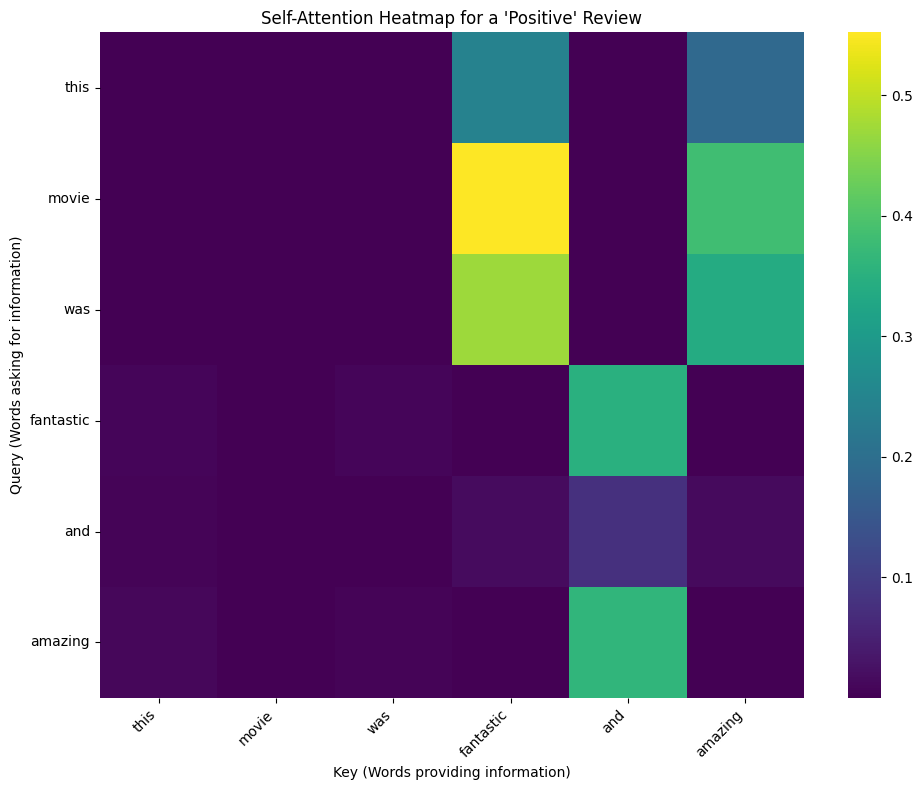

Input Text: 'this movie was fantastic and amazing'
Predicted Sentiment: Positive (Probability: 0.9614)
Logit: 3.2156
Attention matrix shape: (512, 512)
Number of non-padding tokens: 6


Example 2: Negative review


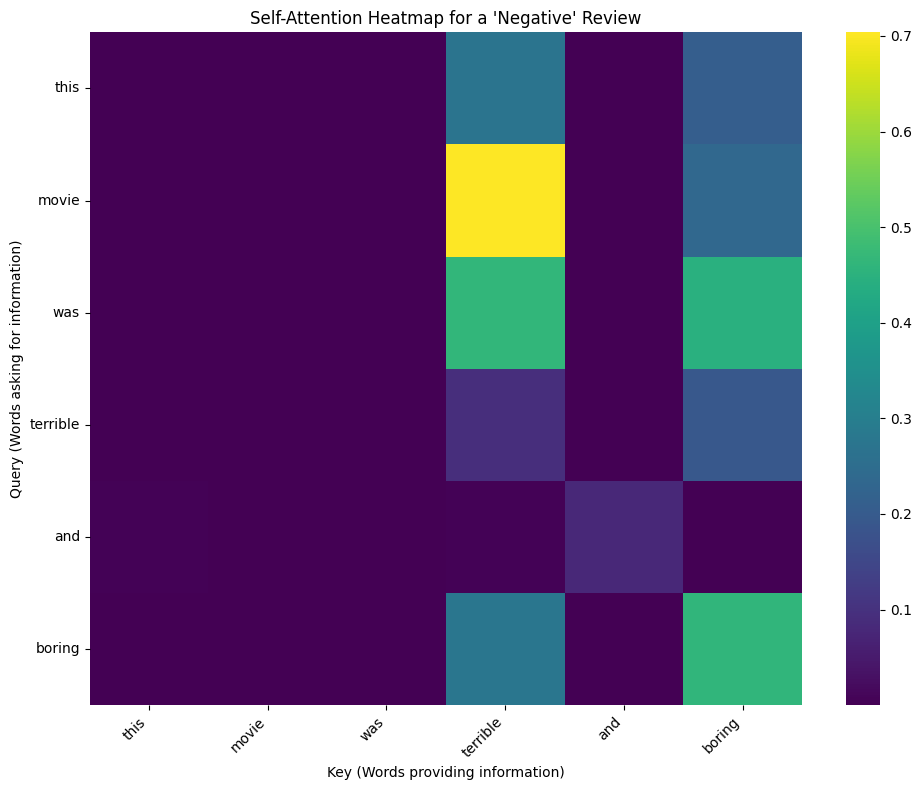

Input Text: 'this movie was terrible and boring'
Predicted Sentiment: Negative (Probability: 0.1565)
Logit: -1.6846
Attention matrix shape: (512, 512)
Number of non-padding tokens: 6


Example 3: Complex review with contrasting elements


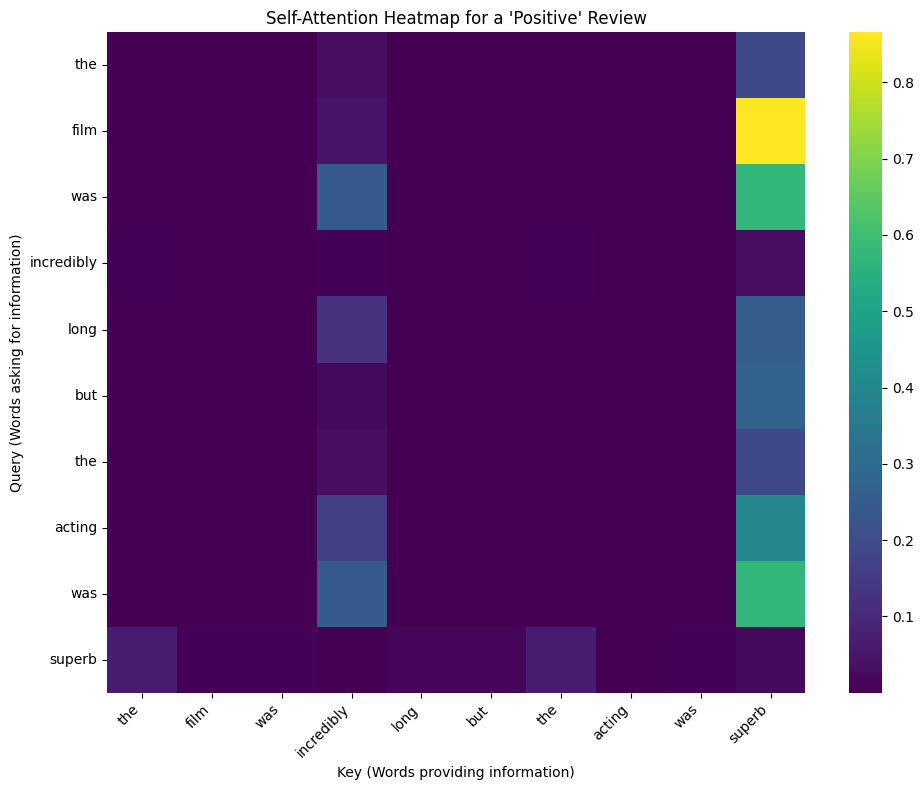

Input Text: 'the film was incredibly long but the acting was superb'
Predicted Sentiment: Positive (Probability: 0.9236)
Logit: 2.4925
Attention matrix shape: (512, 512)
Number of non-padding tokens: 10


('Positive',
 0.9236170649528503,
 array([[8.8753831e-04, 4.0064051e-04, 1.4543154e-04, ..., 1.5461277e-03,
         1.5461277e-03, 1.5461277e-03],
        [1.2061716e-03, 2.7728602e-04, 6.7643443e-05, ..., 1.6271372e-04,
         1.6271372e-04, 1.6271372e-04],
        [4.2910342e-05, 5.3392647e-05, 9.3482213e-06, ..., 3.7382208e-04,
         3.7382208e-04, 3.7382208e-04],
        ...,
        [1.3599870e-03, 1.4517818e-03, 5.9994683e-04, ..., 1.7360185e-03,
         1.7360185e-03, 1.7360185e-03],
        [1.3599870e-03, 1.4517818e-03, 5.9994683e-04, ..., 1.7360185e-03,
         1.7360185e-03, 1.7360185e-03],
        [1.3599870e-03, 1.4517818e-03, 5.9994683e-04, ..., 1.7360185e-03,
         1.7360185e-03, 1.7360185e-03]], dtype=float32))

In [430]:
# Example Usage: Visualizing attention for different types of reviews

# Example 1: Simple positive review
print("Example 1: Simple positive review")
predict_and_visualize_attention(
    "this movie was fantastic and amazing",
    model, word_to_idx, SEQUENCE_LENGTH, glove, torch.device(DEVICE)
)

print("\n" + "="*50 + "\n")

# Example 2: Negative review
print("Example 2: Negative review")
predict_and_visualize_attention(
    "this movie was terrible and boring",
    model, word_to_idx, SEQUENCE_LENGTH, glove, torch.device(DEVICE)
)

print("\n" + "="*50 + "\n")

# Example 3: More complex review with contrasting elements
print("Example 3: Complex review with contrasting elements")
predict_and_visualize_attention(
    "the film was incredibly long but the acting was superb",
    model, word_to_idx, SEQUENCE_LENGTH, glove, torch.device(DEVICE)
)


## Understanding the Attention Visualization

The heatmaps above show how the self-attention mechanism works in practice:

1. **Bright spots** indicate strong attention - these are word pairs that the model considers important for understanding the text
2. **Diagonal elements** (words attending to themselves) are often bright, which is normal in self-attention
3. **Sentiment-relevant words** often have strong connections to each other (e.g., "fantastic" and "amazing" in positive reviews)
4. **Contrasting elements** in complex reviews may show interesting patterns (e.g., "long" vs "superb" in the third example)

This visualization helps us understand:
- Which words the model considers most important
- How the model captures relationships between words
- Whether the attention patterns make intuitive sense for sentiment analysis

The attention mechanism allows the model to focus on relevant parts of the input when making predictions, similar to how humans might emphasize certain words when reading a review.
